In [1]:
suppressMessages(library("limma"))
suppressMessages(library("ggplot2"))
suppressMessages(library("WGCNA"))
options(stringsAsFactors = FALSE)

*
*  Package WGCNA 1.64.1 loaded.
*
*    Important note: It appears that your system supports multi-threading,
*    but it is not enabled within WGCNA in R. 
*    To allow multi-threading within WGCNA with all available cores, use 
*
*          allowWGCNAThreads()
*
*    within R. Use disableWGCNAThreads() to disable threading if necessary.
*    Alternatively, set the following environment variable on your system:
*
*          ALLOW_WGCNA_THREADS=<number_of_processors>
*
*    for example 
*
*          ALLOW_WGCNA_THREADS=8
*
*    To set the environment variable in linux bash shell, type 
*
*           export ALLOW_WGCNA_THREADS=8
*
*     before running R. Other operating systems or shells will
*     have a similar command to achieve the same aim.
*




In [2]:
load("../data/filtered_TMT_Summary_Data_FC.RData")

In [3]:
nCols <- ncol(filtered_TMT_Summary_Data)
nGenes <- nrow(filtered_TMT_Summary_Data)

# additive linear model
addBatchFactor <- c(2,2,1,1,3,3,4,4)
addDiseaseGroup <- factor(rep(addBatchFactor,5))
addDesign <- model.matrix(~addDiseaseGroup + 0)
colnames(addDesign) <- c("Ctl", "AD", "PD","ADPD")

addFit <- lmFit(filtered_TMT_Summary_Data[,7:nCols], addDesign)

contrast.matrix <- makeContrasts(AD-Ctl, PD-Ctl, ADPD-Ctl, levels=addDesign)
addFit2 <- contrasts.fit(addFit, contrast.matrix)
addFit2 <- eBayes(addFit2)
topGenesAdd <- topTable(addFit2, coef=1, adjust="BH")

# interaction linear model
Ctl <-factor(rep(c(0,0,1,1,0,0,0,0),5))
AD <- factor(rep(c(1,1,0,0,0,0,1,1),5))
PD <- factor(rep(c(0,0,0,0,1,1,1,1),5))
intDesign <- model.matrix(~Ctl + AD + PD + AD:PD + 0)
intDesign <- intDesign[,2:5]
colnames(intDesign) <- c("Ctl", "AD", "PD","ADPD")

intFit <- lmFit(filtered_TMT_Summary_Data[,7:nCols], intDesign)

contrast.matrix <- makeContrasts(AD-Ctl, PD-Ctl, ADPD-Ctl, levels=intDesign)
intFit2 <- contrasts.fit(intFit, contrast.matrix)
intFit2 <- eBayes(intFit2)
topGenesInt <- topTable(intFit2, coef=1, adjust="BH")

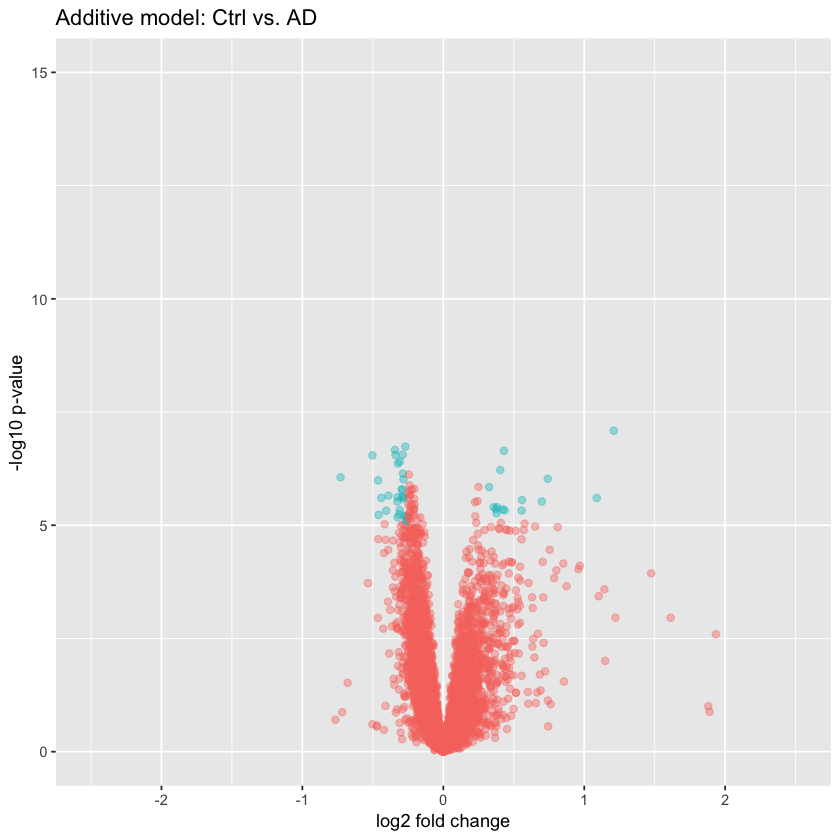

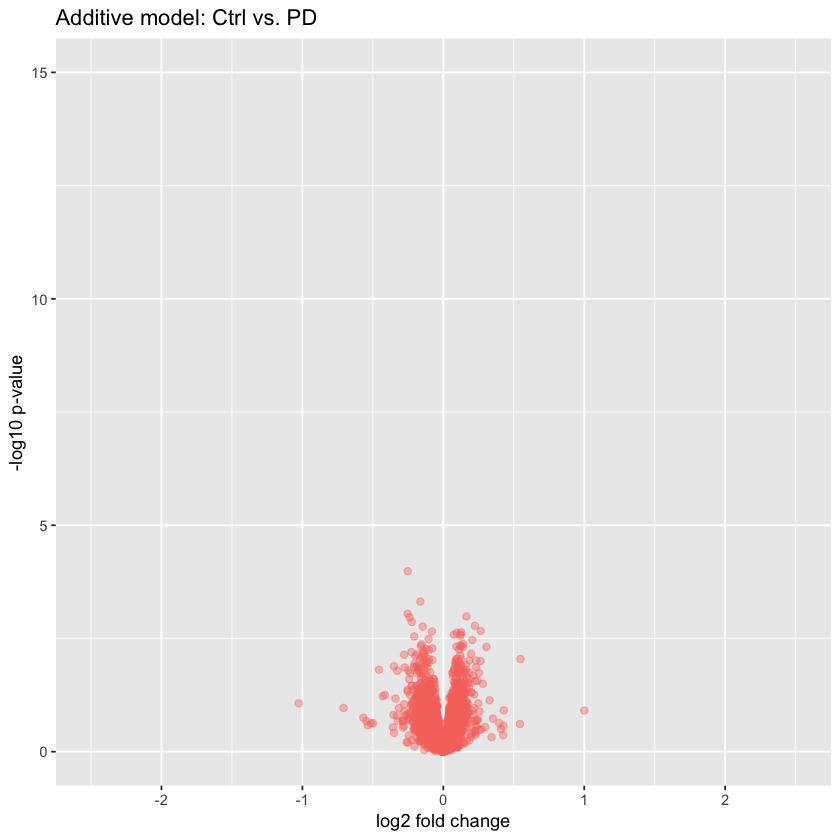

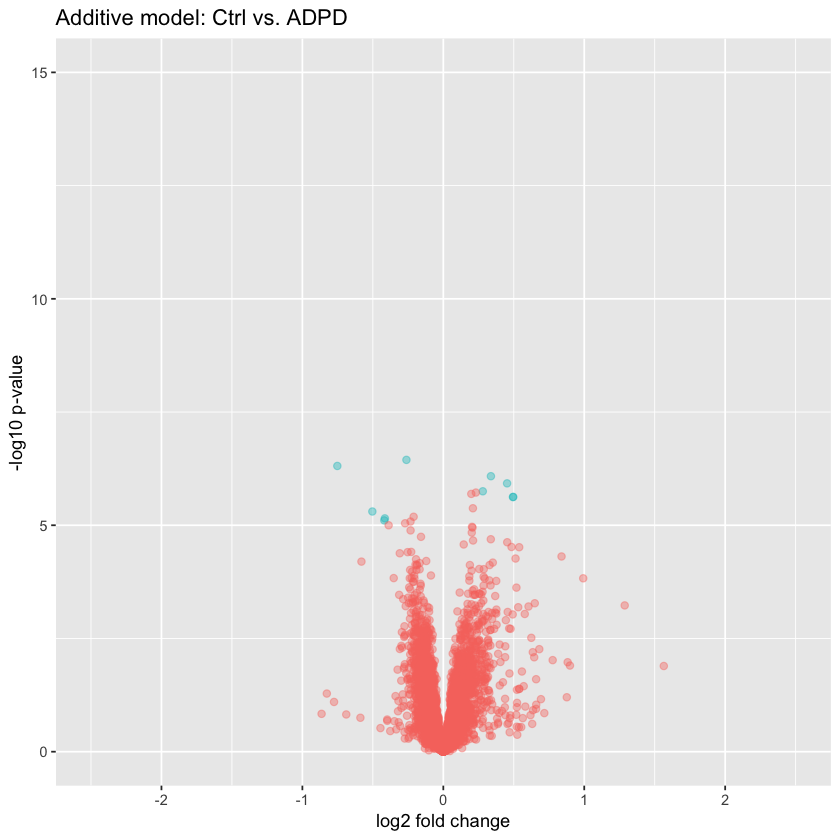

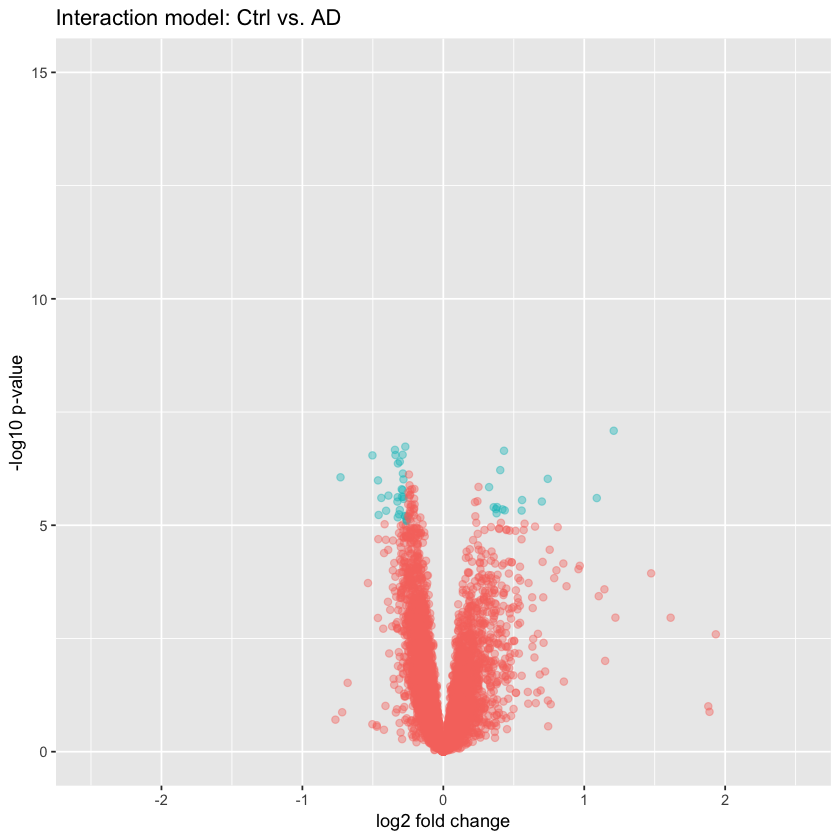

Warning message:
“Removed 5276 rows containing missing values (geom_point).”

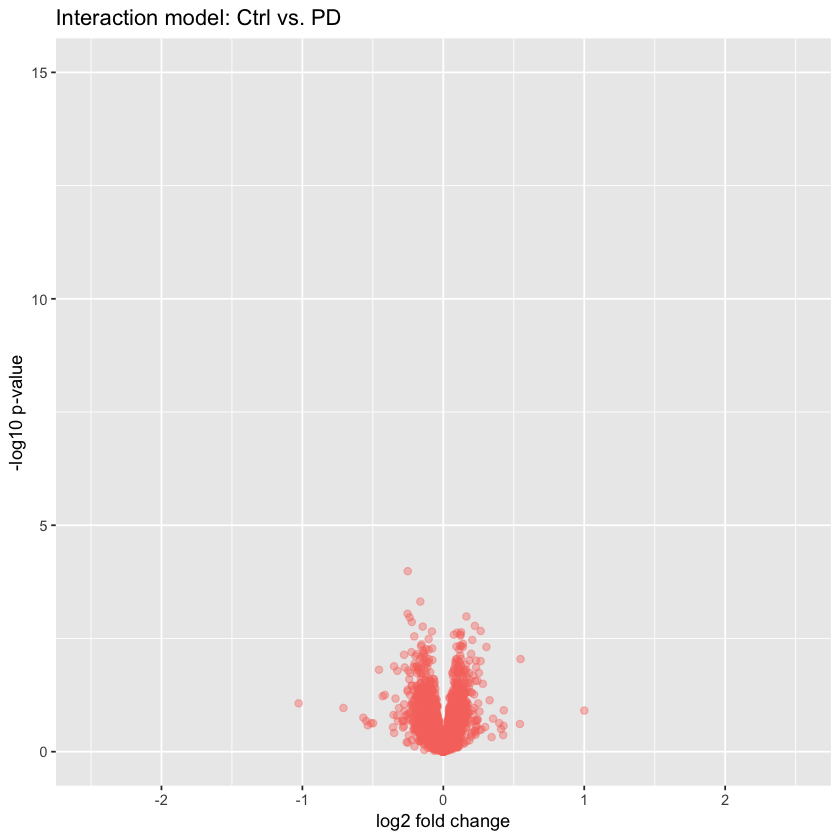

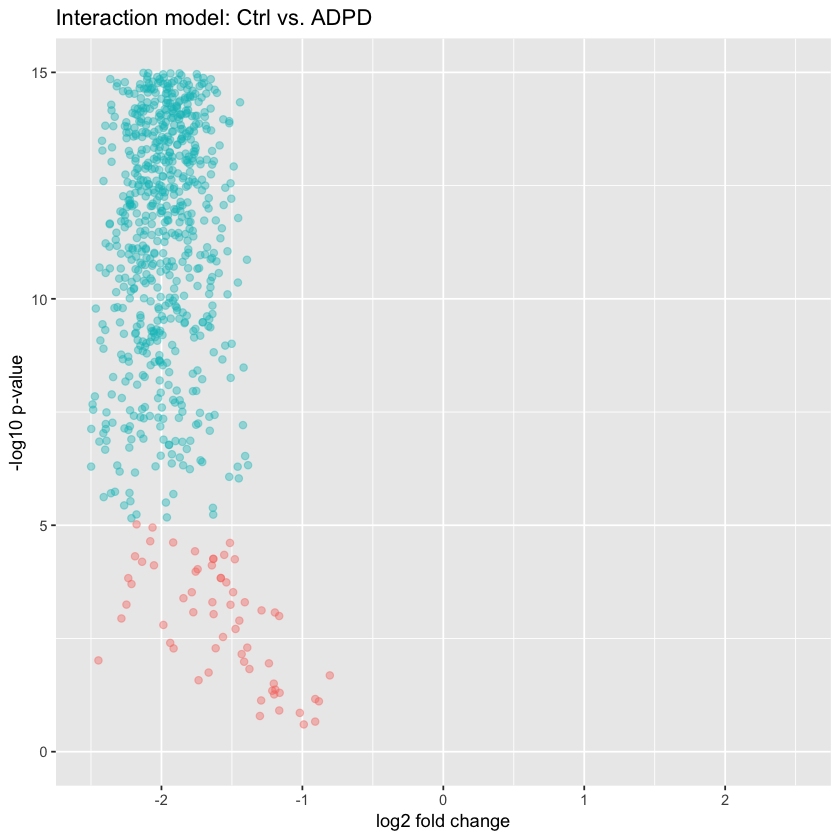

In [4]:
# Generate Log-fold changes
adAddGenes <- topTable(addFit2, coef=1, number=1000000, sort.by="logFC")
pdAddGenes <- topTable(addFit2, coef=2, number=1000000, sort.by="logFC")
adpdAddGenes <- topTable(addFit2, coef=3, number=1000000, sort.by="logFC")

adIntGenes <- topTable(intFit2, coef=1, number=1000000, sort.by="logFC")
pdIntGenes <- topTable(intFit2, coef=2, number=1000000, sort.by="logFC")
adpdIntGenes <- topTable(intFit2, coef=3, number=1000000, sort.by="logFC")

# Add compute expressed genes threshold (TRUE is differentially expressed)
adAddGenes$threshold = as.factor(abs(adAddGenes$logFC) > 0.25 & adAddGenes$P.Value < 0.05/nGenes)
pdAddGenes$threshold = as.factor(abs(pdAddGenes$logFC) > 0.25 & pdAddGenes$P.Value < 0.05/nGenes)
adpdAddGenes$threshold = as.factor(abs(adpdAddGenes$logFC) > 0.25 & adpdAddGenes$P.Value < 0.05/nGenes)

adIntGenes$threshold = as.factor(abs(adIntGenes$logFC) > 0.25 & adIntGenes$P.Value < 0.05/nGenes)
pdIntGenes$threshold = as.factor(abs(pdIntGenes$logFC) > 0.25 & pdIntGenes$P.Value < 0.05/nGenes)
adpdIntGenes$threshold = as.factor(abs(adpdIntGenes$logFC) > 0.25 & adpdIntGenes$P.Value < 0.05/nGenes)

# Generate volcano plots using the additive model.
g1 = ggplot(data=adAddGenes, aes(x=logFC, y=-log10(P.Value), colour=threshold)) +
  geom_point(alpha=0.4, size=1.75) +
  theme(legend.position = "none") +
  xlim(c(-2.5, 2.5)) + ylim(c(0, 15)) +
  xlab("log2 fold change") + ylab("-log10 p-value") + ggtitle('Additive model: Ctrl vs. AD')
g1

g2 = ggplot(data=pdAddGenes, aes(x=logFC, y=-log10(P.Value), colour=threshold)) +
  geom_point(alpha=0.4, size=1.75) +
  theme(legend.position = "none") +
  xlim(c(-2.5, 2.5)) + ylim(c(0, 15)) +
  xlab("log2 fold change") + ylab("-log10 p-value") + ggtitle('Additive model: Ctrl vs. PD')
g2

g3 = ggplot(data=adpdAddGenes, aes(x=logFC, y=-log10(P.Value), colour=threshold)) +
  geom_point(alpha=0.4, size=1.75) +
  theme(legend.position = "none") +
  xlim(c(-2.5, 2.5)) + ylim(c(0, 15)) +
  xlab("log2 fold change") + ylab("-log10 p-value") + ggtitle('Additive model: Ctrl vs. ADPD')
g3

# Generate volcano plots using the interaction model.
g4 = ggplot(data=adIntGenes, aes(x=logFC, y=-log10(P.Value), colour=threshold)) +
  geom_point(alpha=0.4, size=1.75) +
  theme(legend.position = "none") +
  xlim(c(-2.5, 2.5)) + ylim(c(0, 15)) +
  xlab("log2 fold change") + ylab("-log10 p-value") + ggtitle('Interaction model: Ctrl vs. AD')
g4

g5 = ggplot(data=pdIntGenes, aes(x=logFC, y=-log10(P.Value), colour=threshold)) +
  geom_point(alpha=0.4, size=1.75) +
  theme(legend.position = "none") +
  xlim(c(-2.5, 2.5)) + ylim(c(0, 15)) +
  xlab("log2 fold change") + ylab("-log10 p-value") + ggtitle('Interaction model: Ctrl vs. PD')
g5

g6 = ggplot(data=adpdIntGenes, aes(x=logFC, y=-log10(P.Value), colour=threshold)) +
  geom_point(alpha=0.4, size=1.75) +
  theme(legend.position = "none") +
  xlim(c(-2.5, 2.5)) + ylim(c(0, 15)) +
  xlab("log2 fold change") + ylab("-log10 p-value") + ggtitle('Interaction model: Ctrl vs. ADPD')
g6

In [5]:
# Get all differentially expressed genes into a dataframe

ad_ctl <-  as.data.frame((filtered_TMT_Summary_Data[as.integer(rownames(adAddGenes[which(adAddGenes$threshold == TRUE),])), c(1,2,7:nCols)]))

rownames(ad_ctl) <- ad_ctl[,1]
ad_ctl[,1] <- NULL
ad_ctl_data <- ad_ctl[,-1]
ad_ctl_data <- t(ad_ctl_data)

In [6]:
gsg = goodSamplesGenes(ad_ctl_data, verbose = 3);
gsg$allOK

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

In [7]:
# Choose a set of soft-thresholding powers
powers = c(c(1:10), seq(from = 12, to=20, by=2))
# Call the network topology analysis function
sft = pickSoftThreshold(ad_ctl_data, powerVector = powers, verbose = 5)
# Plot the results:
sizeGrWindow(9, 5)
par(mfrow = c(1,2));
cex1 = 0.9;
# Scale-free topology fit index as a function of the soft-thresholding power
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
xlab="Soft Threshold (power)",ylab="Scale Free Topology Model Fit,signed R^2",type="n",
main = paste("Scale independence"));
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
labels=powers,cex=cex1,col="red");
# this line corresponds to using an R^2 cut-off of h
abline(h=0.70,col="red")
# Mean connectivity as a function of the soft-thresholding power
plot(sft$fitIndices[,1], sft$fitIndices[,5],
xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")

pickSoftThreshold: will use block size 45.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 45 of 45


Warning message:
“executing %dopar% sequentially: no parallel backend registered”

   Power SFT.R.sq   slope truncated.R.sq mean.k. median.k. max.k.
1      1  0.24100 21.9000        0.02410  30.500    31.100  34.20
2      2  0.59600  2.5100        0.49700  21.700    22.200  27.10
3      3  0.54700  1.3900        0.41700  15.800    16.000  21.70
4      4  0.39200  0.8810        0.24900  11.700    11.800  17.60
5      5  0.34800  0.4270        0.29400   8.850     8.820  14.40
6      6  0.15200  0.2090       -0.03080   6.780     6.680  11.90
7      7  0.00823  0.0636       -0.25900   5.270     5.140   9.95
8      8  0.13700 -0.1870        0.11800   4.150     4.030   8.35
9      9  0.18600 -0.2200        0.07410   3.300     3.200   7.06
10    10  0.18800 -0.2490       -0.00281   2.660     2.500   5.99
11    12  0.55900 -0.4190        0.48700   1.770     1.630   4.39
12    14  0.10300 -2.0900       -0.12600   1.210     1.110   3.28
13    16  0.63800 -0.6060        0.56000   0.860     0.780   2.48
14    18  0.69800 -0.5810        0.63800   0.625     0.568   1.90
15    20  

In [8]:
net = blockwiseModules(ad_ctl_data, power = 18,
TOMType = "unsigned", minModuleSize = 1,
reassignThreshold = 0, mergeCutHeight = 0.1,
numericLabels = TRUE, pamRespectsDendro = FALSE,
saveTOMs = TRUE,
saveTOMFileBase = "../data/ad_ctl_tom",
verbose = 3)

 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
 ..Working on block 1 .
    TOM calculation: adjacency..
    ..will not use multithreading.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
   ..saving TOM for block 1 into file ../data/ad_ctl_tom-block.1.RData
 ....clustering..
 ....detecting modules..
 ....calculating module eigengenes..
 ....checking kME in modules..
 ..merging modules that are too close..
     mergeCloseModules: Merging modules whose distance is less than 0.1
       Calculating new MEs...


In [9]:
table(net$colors)


 0  1  2  3  4  5  6  7  8 
 5 18  4  4  3  3  3  3  2 

In [10]:
# open a graphics window
sizeGrWindow(12, 9)
# Convert labels to colors for plotting
mergedColors = labels2colors(net$colors)
# Plot the dendrogram and the module colors underneath
plotDendroAndColors(net$dendrograms[[1]], mergedColors[net$blockGenes[[1]]],
"Module colors",
dendroLabels = FALSE, hang = 0.03,
addGuide = TRUE, guideHang = 0.05)

Warning message in pmin(objHeights[dendro$order][floor(positions)], objHeights[dendro$order][ceiling(positions)]):
“an argument will be fractionally recycled”

In [11]:
moduleLabels = net$colors
moduleColors = labels2colors(net$colors)
MEs = net$MEs;
geneTree = net$dendrograms[[1]];
save(MEs, moduleLabels, moduleColors, geneTree,
file = "../data/WGCNA_FC.RData")

In [12]:
# Might have to do manual construction of blocks to get the maximally connected genes

get_max_conn_genes <- function(data, softPower, min_mod_size){
  softPower = softPower;
  adjacency = adjacency(data, power = softPower);
  
  # Turn adjacency into topological overlap
  TOM = TOMsimilarity(adjacency);
  dissTOM = 1-TOM
  
  # Call the hierarchical clustering function
  geneTree = hclust(as.dist(dissTOM), method = "average");
  # Plot the resulting clustering tree (dendrogram)
  sizeGrWindow(12,9)
  plot(geneTree, xlab="", sub="", main = "Gene clustering on TOM-based dissimilarity",
  labels = FALSE, hang = 0.04);
  
  minModuleSize = 1;
  # Module identification using dynamic tree cut:
  dynamicMods = cutreeDynamic(dendro = geneTree, distM = dissTOM,
  deepSplit = 2, pamRespectsDendro = FALSE,
  minClusterSize = min_mod_size);
  table(dynamicMods)
  
  # Convert numeric lables into colors
  dynamicColors = labels2colors(dynamicMods)
  table(dynamicColors)
  # Plot the dendrogram and colors underneath
  sizeGrWindow(8,6)
  plotDendroAndColors(geneTree, dynamicColors, "Dynamic Tree Cut",
  dendroLabels = FALSE, hang = 0.03,
  addGuide = TRUE, guideHang = 0.05,
  main = "Gene dendrogram and module colors")
  
  # Maximally connected gene, let's call it mc_gene
  # For each cluster, find elements in that cluster, sum up the corresponding row from the     adjacency matrix.
  mc_genes = list()
  for(i in c(1:max(dynamicMods))){
    all_row_indices = which(dynamicMods == i)
    max_val = -1
    max_idx = -1
    for(id in all_row_indices){
      curr_sum = sum(adjacency[id,])
      if(curr_sum>max_val){
        max_val = curr_sum
        max_idx = id
      }
    }
    mc_genes[[i]] <- rownames(ad_ctl[max_idx,])
  }
  
  return(mc_genes)
}

In [13]:
# AD vs Ctrl, additive model

# Get all differentially expressed genes into a dataframe
ad_ctl <-  as.data.frame((filtered_TMT_Summary_Data[as.integer(rownames(adAddGenes[which(adAddGenes$threshold == TRUE),])), c(1,2,7:nCols)]))

rownames(ad_ctl) <- ad_ctl[,1]
ad_ctl[,1] <- NULL
ad_ctl_data <- ad_ctl[,-1]
ad_ctl_data <- t(ad_ctl_data)

gsg = goodSamplesGenes(ad_ctl_data, verbose = 3);
gsg$allOK

# Choose a set of soft-thresholding powers
powers = c(c(1:10), seq(from = 12, to=20, by=2))
# Call the network topology analysis function
sft = pickSoftThreshold(ad_ctl_data, powerVector = powers, verbose = 5)
# Plot the results:
sizeGrWindow(9, 5)
par(mfrow = c(1,2));
cex1 = 0.9;
# Scale-free topology fit index as a function of the soft-thresholding power
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
xlab="Soft Threshold (power)",ylab="Scale Free Topology Model Fit,signed R^2",type="n",
main = paste("Scale independence"));
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
labels=powers,cex=cex1,col="red");
# this line corresponds to using an R^2 cut-off of h
abline(h=0.70,col="red")
# Mean connectivity as a function of the soft-thresholding power
plot(sft$fitIndices[,1], sft$fitIndices[,5],
xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

pickSoftThreshold: will use block size 45.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 45 of 45
   Power SFT.R.sq   slope truncated.R.sq mean.k. median.k. max.k.
1      1  0.24100 21.9000        0.02410  30.500    31.100  34.20
2      2  0.59600  2.5100        0.49700  21.700    22.200  27.10
3      3  0.54700  1.3900        0.41700  15.800    16.000  21.70
4      4  0.39200  0.8810        0.24900  11.700    11.800  17.60
5      5  0.34800  0.4270        0.29400   8.850     8.820  14.40
6      6  0.15200  0.2090       -0.03080   6.780     6.680  11.90
7      7  0.00823  0.0636       -0.25900   5.270     5.140   9.95
8      8  0.13700 -0.1870        0.11800   4.150     4.030   8.35
9      9  0.18600 -0.2200        0.07410   3.300     3.200   7.06
10    10  0.18800 -0.2490       -0.00281   2.660     2.500   5.99
11    12  0.55900 -0.4190        0.48700   1.770     1.630   4.39
12    14  0.10300 -2.0900       -0.12600   1.210     1.110 

In [14]:
mc_genes = get_max_conn_genes(ad_ctl_data, 18, 1)
unlist(mc_genes)

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.
 ..cutHeight not given, setting it to 0.997  ===>  99% of the (truncated) height range in dendro.
 ..done.


Warning message in pmin(objHeights[dendro$order][floor(positions)], objHeights[dendro$order][ceiling(positions)]):
“an argument will be fractionally recycled”

[1] "Q9Y2J0"   "Q9UIW2"   "Q13574-3" "P04792"   "Q16795"   "P51178"   "Q9Y617"  
[8] "Q9ULD0"   "Q96RR4"

In [15]:
# PD vs Ctrl, additive model

# Get all differentially expressed genes into a dataframe
pd_ctl <-  as.data.frame((filtered_TMT_Summary_Data[as.integer(rownames(pdAddGenes[which(pdAddGenes$threshold == TRUE),])), c(1,2,7:nCols)]))

rownames(pd_ctl) <- pd_ctl[,1]
pd_ctl[,1] <- NULL
pd_ctl_data <- pd_ctl[,-1]
pd_ctl_data <- t(pd_ctl_data)

#gsg = goodSamplesGenes(pd_ctl_data, verbose = 3);
#gsg$allOK

# Choose a set of soft-thresholding powers
powers = c(c(1:10), seq(from = 12, to=20, by=2))
# Call the network topology analysis function
sft = pickSoftThreshold(pd_ctl_data, powerVector = powers, verbose = 5)
# Plot the results:
sizeGrWindow(9, 5)
par(mfrow = c(1,2));
cex1 = 0.9;
# Scale-free topology fit index as a function of the soft-thresholding power
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
xlab="Soft Threshold (power)",ylab="Scale Free Topology Model Fit,signed R^2",type="n",
main = paste("Scale independence"));
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
labels=powers,cex=cex1,col="red");
# this line corresponds to using an R^2 cut-off of h
abline(h=0.70,col="red")
# Mean connectivity as a function of the soft-thresholding power
plot(sft$fitIndices[,1], sft$fitIndices[,5],
xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")

ERROR: Error in pickSoftThreshold(pd_ctl_data, powerVector = powers, verbose = 5): The input data data contain fewer than 3 rows (nodes).
This would result in a trivial correlation network.


In [16]:
#Analyze all of them since fewer than 3 genes
rownames(pd_ctl)

pd_ctl

pd_ctl_data

character(0)

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”

Gene,AD1,AD2,CTL1,CTL2,PD1,PD2,ADPD1,ADPD2,AD3,⋯,ADPD7,ADPD8,AD9,AD10,CTL9,CTL10,PD9,PD10,ADPD9,ADPD10


AD1
AD2
CTL1
CTL2
PD1
PD2
ADPD1
ADPD2
AD3
AD4
CTL3


In [17]:
# ADPD vs Ctrl, additive model

# Get all differentially expressed genes into a dataframe
adpd_ctl <-  as.data.frame((filtered_TMT_Summary_Data[as.integer(rownames(adpdAddGenes[which(adpdAddGenes$threshold == TRUE),])), c(1,2,7:nCols)]))

rownames(adpd_ctl) <- adpd_ctl[,1]
adpd_ctl[,1] <- NULL
adpd_ctl_data <- adpd_ctl[,-1]
adpd_ctl_data <- t(adpd_ctl_data)

#gsg = goodSamplesGenes(pd_ctl_data, verbose = 3);
#gsg$allOK

# Choose a set of soft-thresholding powers
powers = c(c(1:10), seq(from = 12, to=20, by=2))
# Call the network topology analysis function
sft = pickSoftThreshold(adpd_ctl_data, powerVector = powers, verbose = 5)
# Plot the results:
sizeGrWindow(9, 5)
par(mfrow = c(1,2));
cex1 = 0.9;
# Scale-free topology fit index as a function of the soft-thresholding power
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
xlab="Soft Threshold (power)",ylab="Scale Free Topology Model Fit,signed R^2",type="n",
main = paste("Scale independence"));
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
labels=powers,cex=cex1,col="red");
# this line corresponds to using an R^2 cut-off of h
abline(h=0.70,col="red")
# Mean connectivity as a function of the soft-thresholding power
plot(sft$fitIndices[,1], sft$fitIndices[,5],
xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")

pickSoftThreshold: will use block size 10.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 10 of 10
   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1 2.18e-02 23.100        -0.2420   5.880    5.8600   6.36
2      2 7.27e-02 20.500        -0.1700   3.950    3.9000   4.58
3      3 5.97e-03  3.940        -0.2420   2.730    2.6900   3.38
4      4 1.34e-05  0.139        -0.2480   1.940    2.0000   2.55
5      5 3.42e-02  4.940        -0.2410   1.430    1.4300   1.96
6      6 1.28e-03  0.831        -0.1600   1.080    1.0300   1.55
7      7 2.06e-03 -0.816        -0.2600   0.850    0.7560   1.26
8      8 4.84e-02 -2.870        -0.1590   0.688    0.5600   1.17
9      9 1.00e-01 -3.870        -0.1260   0.574    0.4190   1.11
10    10 1.18e-01 -4.750        -0.0537   0.492    0.3170   1.07
11    12 1.23e-01 -4.380        -0.0408   0.389    0.1890   1.03
12    14 2.32e-01 -5.190         0.0588   0.330    0.1180   1.01
13    

In [18]:
mc_genes = get_max_conn_genes(ad_ctl_data, 14, 1)
unlist(mc_genes)

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.
 ..cutHeight not given, setting it to 0.996  ===>  99% of the (truncated) height range in dendro.
 ..done.


Warning message in pmin(objHeights[dendro$order][floor(positions)], objHeights[dendro$order][ceiling(positions)]):
“an argument will be fractionally recycled”

[1] "Q9Y2J0"   "Q9UIW2"   "Q13574-3" "Q16795"   "P04792"   "O14949"   "Q96RR4"

In [19]:
# AD vs Ctrl, interaction model

# Get all differentially expressed genes into a dataframe
ad_ctl <-  as.data.frame((filtered_TMT_Summary_Data[as.integer(rownames(adIntGenes[which(adIntGenes$threshold == TRUE),])), c(1,2,7:nCols)]))

rownames(ad_ctl) <- ad_ctl[,1]
ad_ctl[,1] <- NULL
ad_ctl_data <- ad_ctl[,-1]
ad_ctl_data <- t(ad_ctl_data)

gsg = goodSamplesGenes(ad_ctl_data, verbose = 3);
gsg$allOK

# Choose a set of soft-thresholding powers
powers = c(c(1:10), seq(from = 12, to=20, by=2))
# Call the network topology analysis function
sft = pickSoftThreshold(ad_ctl_data, powerVector = powers, verbose = 5)
# Plot the results:
sizeGrWindow(9, 5)
par(mfrow = c(1,2));
cex1 = 0.9;
# Scale-free topology fit index as a function of the soft-thresholding power
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
xlab="Soft Threshold (power)",ylab="Scale Free Topology Model Fit,signed R^2",type="n",
main = paste("Scale independence"));
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
labels=powers,cex=cex1,col="red");
# this line corresponds to using an R^2 cut-off of h
abline(h=0.70,col="red")
# Mean connectivity as a function of the soft-thresholding power
plot(sft$fitIndices[,1], sft$fitIndices[,5],
xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

pickSoftThreshold: will use block size 45.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 45 of 45
   Power SFT.R.sq   slope truncated.R.sq mean.k. median.k. max.k.
1      1  0.24100 21.9000        0.02410  30.500    31.100  34.20
2      2  0.59600  2.5100        0.49700  21.700    22.200  27.10
3      3  0.54700  1.3900        0.41700  15.800    16.000  21.70
4      4  0.39200  0.8810        0.24900  11.700    11.800  17.60
5      5  0.34800  0.4270        0.29400   8.850     8.820  14.40
6      6  0.15200  0.2090       -0.03080   6.780     6.680  11.90
7      7  0.00823  0.0636       -0.25900   5.270     5.140   9.95
8      8  0.13700 -0.1870        0.11800   4.150     4.030   8.35
9      9  0.18600 -0.2200        0.07410   3.300     3.200   7.06
10    10  0.18800 -0.2490       -0.00281   2.660     2.500   5.99
11    12  0.55900 -0.4190        0.48700   1.770     1.630   4.39
12    14  0.10300 -2.0900       -0.12600   1.210     1.110 

In [20]:
mc_genes = get_max_conn_genes(ad_ctl_data, 18, 1)
unlist(mc_genes)

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.
 ..cutHeight not given, setting it to 0.997  ===>  99% of the (truncated) height range in dendro.
 ..done.


Warning message in pmin(objHeights[dendro$order][floor(positions)], objHeights[dendro$order][ceiling(positions)]):
“an argument will be fractionally recycled”

[1] "Q9Y2J0"   "Q9UIW2"   "Q13574-3" "P04792"   "Q16795"   "P51178"   "Q9Y617"  
[8] "Q9ULD0"   "Q96RR4"

In [21]:
# PD vs Ctrl

# Same case, no differentially expressed genes

In [22]:
# ADPD vs Ctrl

# Get all differentially expressed genes into a dataframe
adpd_ctl <-  as.data.frame((filtered_TMT_Summary_Data[as.integer(rownames(adpdIntGenes[which(adpdIntGenes$threshold == TRUE),])), c(1,2,7:nCols)]))

rownames(adpd_ctl) <- adpd_ctl[,1]
adpd_ctl[,1] <- NULL
adpd_ctl_data <- adpd_ctl[,-1]
adpd_ctl_data <- t(adpd_ctl_data)

gsg = goodSamplesGenes(adpd_ctl_data, verbose = 3);
gsg$allOK

# Choose a set of soft-thresholding powers
powers = c(c(1:10), seq(from = 12, to=20, by=2))
# Call the network topology analysis function
sft = pickSoftThreshold(adpd_ctl_data, powerVector = powers, verbose = 5)
# Plot the results:
sizeGrWindow(9, 5)
par(mfrow = c(1,2));
cex1 = 0.9;
# Scale-free topology fit index as a function of the soft-thresholding power
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
xlab="Soft Threshold (power)",ylab="Scale Free Topology Model Fit,signed R^2",type="n",
main = paste("Scale independence"));
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
labels=powers,cex=cex1,col="red");
# this line corresponds to using an R^2 cut-off of h
abline(h=0.70,col="red")
# Mean connectivity as a function of the soft-thresholding power
plot(sft$fitIndices[,1], sft$fitIndices[,5],
xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

pickSoftThreshold: will use block size 5931.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 5931 of 5931
   Power SFT.R.sq  slope truncated.R.sq  mean.k. median.k. max.k.
1      1   0.0144 -0.225          0.907 1390.000  1.38e+03 2340.0
2      2   0.5400 -1.080          0.947  506.000  4.62e+02 1270.0
3      3   0.7530 -1.400          0.959  228.000  1.84e+02  803.0
4      4   0.8250 -1.520          0.972  118.000  8.06e+01  550.0
5      5   0.8630 -1.560          0.982   66.700  3.81e+01  398.0
6      6   0.8670 -1.610          0.981   40.600  1.90e+01  299.0
7      7   0.8840 -1.620          0.986   26.100  9.96e+00  232.0
8      8   0.8940 -1.630          0.991   17.600  5.55e+00  184.0
9      9   0.8940 -1.640          0.985   12.200  3.23e+00  149.0
10    10   0.9010 -1.630          0.991    8.790  1.93e+00  123.0
11    12   0.9020 -1.640          0.993    4.890  9.05e-01   86.0
12    14   0.8870 -1.660          0.979    2.940  3.9

In [23]:
mc_genes = get_max_conn_genes(ad_ctl_data, 8, 1)
unlist(mc_genes)

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.
 ..cutHeight not given, setting it to 0.968  ===>  99% of the (truncated) height range in dendro.
 ..done.


Warning message in pmin(objHeights[dendro$order][floor(positions)], objHeights[dendro$order][ceiling(positions)]):
“an argument will be fractionally recycled”

[1] "Q9UIW2"   "Q9Y2J0"   "Q13574-3" "P04792"   "O14949"   "Q16795"   "Q9H4F8-2"